# <center>CSCI 6516 - Machine Learning for Big Data</center><br><center>(Fall 2023)</center>

# <center>Assignment 3</center>

### Submitted by:
**Arihant Dugar**<br>
**B00917961**<br>
**ar968345@dal.ca**<br>

In [116]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import skfuzzy as fuzz
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

#### [1] Prepare the dataset by applying data transformation. Which method of transformation did you choose? Explain your rationality behind it.

In [2]:
training_data = pd.read_csv('data/sign_mnist_train.csv')
testing_data = pd.read_csv('data/sign_mnist_test.csv')
training_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
print('\x1b[1;31m'+'Check for NaN values in data :'+'\x1b[0m')
training_data.isna().sum()

Check for NaN values in data :


label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [4]:
print('\x1b[1;31m'+'Total Records :'+'\x1b[0m', len(training_data))
print('\x1b[1;31m'+'Duplicate Records :'+'\x1b[0m', len(training_data[training_data.duplicated()]))

Total Records : 27455
Duplicate Records : 0


    Labels  Count Alphabet
0        0   1126        A
1        1   1010        B
2        2   1144        C
3        3   1196        D
4        4    957        E
5        5   1204        F
6        6   1090        G
7        7   1013        H
8        8   1162        I
9       10   1114        K
10      11   1241        L
11      12   1055        M
12      13   1151        N
13      14   1196        O
14      15   1088        P
15      16   1279        Q
16      17   1294        R
17      18   1199        S
18      19   1186        T
19      20   1161        U
20      21   1082        V
21      22   1225        W
22      23   1164        X
23      24   1118        Y


Visual Analysis of data training data :




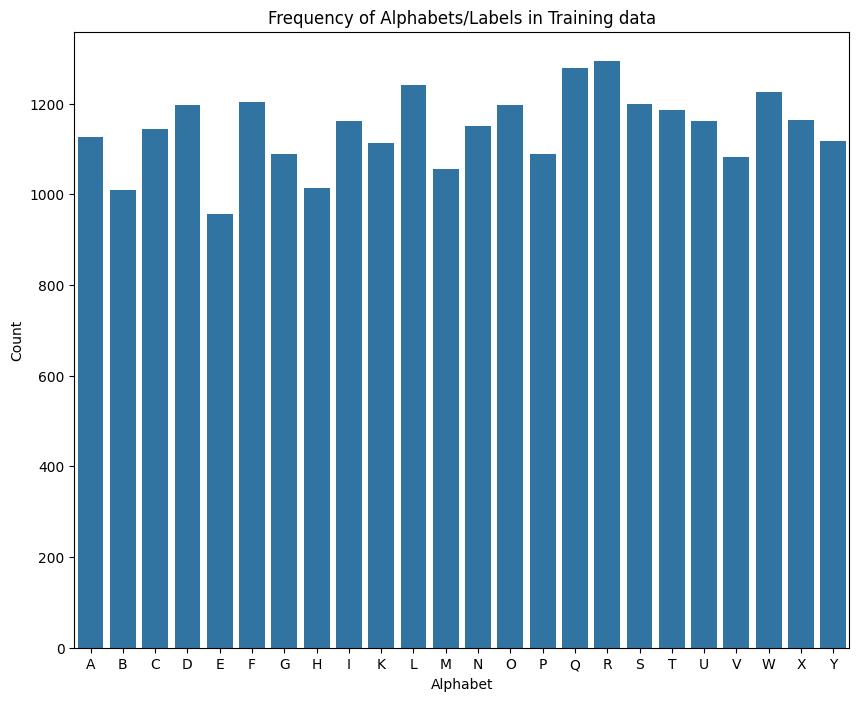

In [5]:
label_counts = training_data['label'].value_counts().reset_index().sort_values(by='label')
label_counts.reset_index(drop=True, inplace=True)
label_counts['Alphabet'] = label_counts['label'].apply(lambda x: chr(x + ord('A')))
label_counts.columns = ['Labels', 'Count', 'Alphabet']
print(label_counts)

print('\n\n\x1b[1;31m'+'Visual Analysis of data training data :'+'\x1b[0m\n\n')

plt.figure(figsize=(10,8))
sns.barplot(data=label_counts, x="Alphabet", y="Count")
plt.title('Frequency of Alphabets/Labels in Training data')
plt.show()


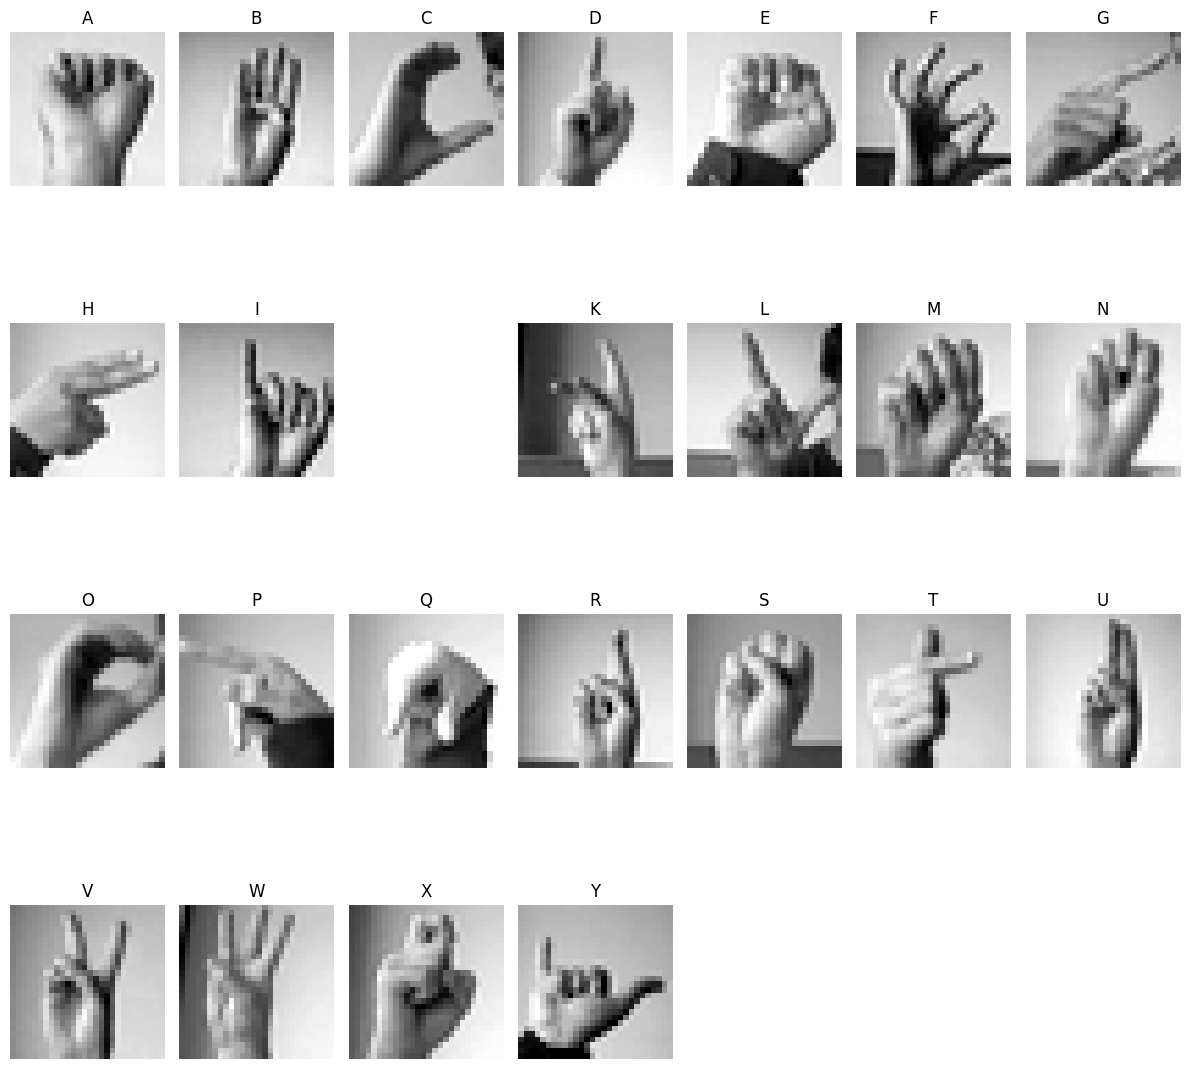

In [6]:
images = training_data.drop('label', axis=1).values / 255.0  

# Set up the figure for displaying images
plt.figure(figsize=(12, 12))

# Iterate through labels to display corresponding images
for i, label in enumerate(label_counts['Alphabet']):
    if i >= 9:
        i = i+1
    # Find the index of the first occurrence of the current label
    idx = training_data[training_data['label'] == i].index[0]
    
    # Extract the image corresponding to the label
    img = images[idx].reshape(28, 28)
    
    # Create subplots to display images
    plt.subplot(4, 7, i + 1)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [77]:
#Normalizing the pixel values to range from 0 to 1, aiding in faster convergence during model training
print('\n\n\x1b[1;31m'+'Normalizing the pixel values to range from 0 to 1 :'+'\x1b[0m\n\n')
scaler = MinMaxScaler()
training_data.iloc[:, 1:] = scaler.fit_transform(training_data.iloc[:,1:])
testing_data.iloc[:, 1:] = scaler.fit_transform(testing_data.iloc[:,1:])
training_data.head()



Normalizing the pixel values to range from 0 to 1 :




,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,0.419608,0.462745,0.498039,0.525490,0.545098,0.560784,0.572549,0.588235,0.600000,...,0.811765,0.811765,0.811765,0.811765,0.807843,0.807843,0.807843,0.800000,0.796078,0.792157
1,6,0.607843,0.615686,0.611765,0.611765,0.611765,0.615686,0.611765,0.619608,0.619608,...,0.270588,0.584314,0.501961,0.341176,0.368627,0.639216,0.686275,0.403922,0.529412,0.584314
2,2,0.733333,0.737255,0.737255,0.733333,0.733333,0.729412,0.733333,0.737255,0.733333,...,0.792157,0.788235,0.784314,0.780392,0.776471,0.780392,0.776471,0.764706,0.760784,0.764706
3,2,0.827451,0.827451,0.831373,0.831373,0.827451,0.823529,0.827451,0.823529,0.823529,...,0.921569,0.917647,0.913725,0.905882,0.901961,0.886275,0.882353,0.870588,0.898039,0.639216
4,13,0.643137,0.654902,0.666667,0.674510,0.690196,0.701961,0.705882,0.721569,0.725490,...,0.360784,0.411765,0.411765,0.423529,0.521569,0.639216,0.615686,0.639216,0.643137,0.701961


### Reason for Normalizing Pixel Values:

1. **Enhanced Model Performance:** 
   - Neural networks often perform better when input features are within a similar range. 
   - Normalizing pixel values between 0 and 1 helps in creating a consistent scale for the input features.

2. **Faster Convergence:** 
   - Normalization assists in stabilizing the training process by preventing overly large or small input values. 
   - This aids in faster convergence during gradient descent optimization while training the model.

3. **Gradient Descent Efficiency:** 
   - Standardizing the range of input features helps in avoiding potential issues such as vanishing or exploding gradients, which could hinder the optimization process during training.

4. **Improved Generalization:** 
   - Normalization can contribute to better generalization by preventing the dominance of certain features due to their larger magnitude compared to others.



Visual Analysis of data training data after Normalization :




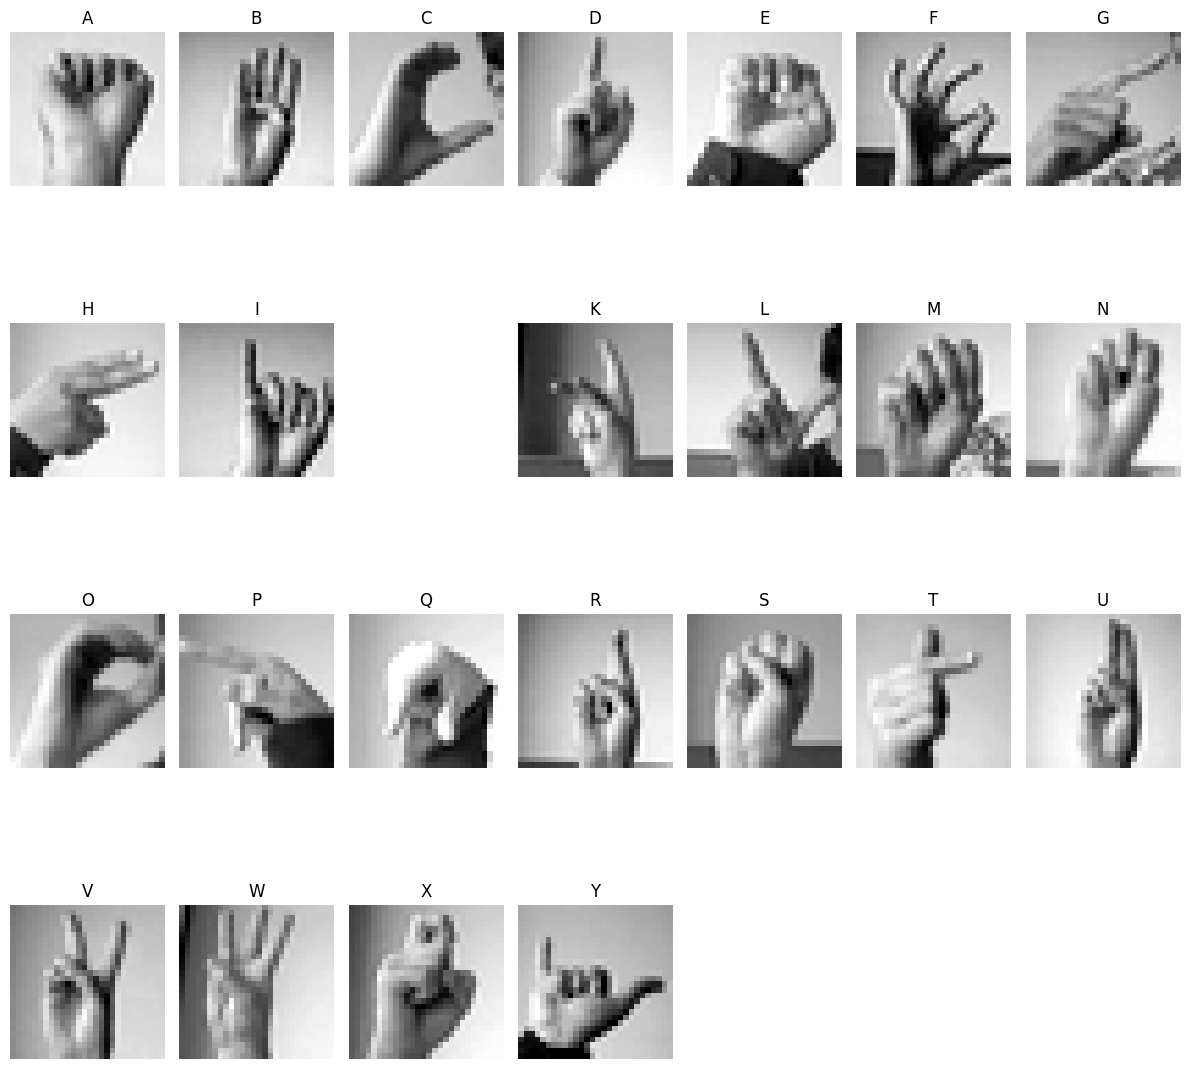

In [8]:
print('\n\n\x1b[1;31m'+'Visual Analysis of data training data after Normalization :'+'\x1b[0m\n\n')

# Set up the figure for displaying images
plt.figure(figsize=(12, 12))

# Iterate through labels to display corresponding images
for i, label in enumerate(label_counts['Alphabet']):
    if i >= 9:
        i = i+1
    # Find the index of the first occurrence of the current label
    idx = training_data[training_data['label'] == i].index[0]
    
    # Extract the image corresponding to the label
    img = images[idx].reshape(28, 28)
    
    # Create subplots to display images
    plt.subplot(4, 7, i + 1)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [165]:
X_train = training_data.drop('label', axis=1).values
y_train = training_data['label'].values

X_test = testing_data.drop('label', axis=1).values
y_test = testing_data['label'].values

# Split the data into training and validation sets (80% training, 20% testing)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

pca = PCA(n_components = 2)
X_train, X_test, X_val = pca.fit_transform(X_train), pca.fit_transform(X_test), pca.fit_transform(X_val)

I have used PCA to reduce the number of features (or dimensions) while retaining most of the important information. In this case, by setting n_components to 2, PCA is reducing the high-dimensional data to a two-dimensional space. This reduction is beneficial for visualization purposes, especially when dealing with datasets with many features.

####  [2] Apply the k-means algorithm to Sign Language MNIST dataset.

#### a. Change the number of clusters from 10 to 200 with the step size of 10. Show the performance of the algorithm based on accuracy and the objective function value for each cluster number

In [26]:
# Initialize lists to store accuracy, inertia and silhouette Avg
accuracy_list_kmeans = []
inertia_list_kmeans = []
silhouette_avg_kmeans = []

# Range of clusters from 10 to 200 with step size 10
for i in range(10, 201, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(X_train)

    y_pred = kmeans.predict(X_val)
    
    # Calculate accuracy and inertia
    accuracy = accuracy_score(y_val, y_pred)
    inertia = kmeans.inertia_
    
    # Append accuracy and inertia to the lists
    accuracy_list_kmeans.append(accuracy)
    inertia_list_kmeans.append(inertia)
    silhouette_avg_kmeans.append(silhouette_score(X_val, y_pred))

In [27]:
j = 0
for i in range(10, 201, 10):
    print('\n\x1b[1;31m'+'Clusters :'+'\x1b[0m', i)
    print('\x1b[1;31m'+'Accuracy :'+'\x1b[0m', accuracy_list_kmeans[j]*100, '%')
    print('\x1b[1;31m'+'Objective Function :'+'\x1b[0m', inertia_list_kmeans[j])
    print('\x1b[1;31m'+'Silhoutte Average :'+'\x1b[0m', silhouette_avg_kmeans[j])
    j+=1


Clusters : 10
Accuracy : 6.064469131305773 %
Objective Function : 30287.278941159886
Silhoutte Average : 0.32403036364251947

Clusters : 20
Accuracy : 5.026406847568749 %
Objective Function : 15852.660861665832
Silhoutte Average : 0.3252065306064282

Clusters : 30
Accuracy : 3.64232380258605 %
Objective Function : 10766.456262085001
Silhoutte Average : 0.31561292562607624

Clusters : 40
Accuracy : 2.622473137861956 %
Objective Function : 8217.989680130326
Silhoutte Average : 0.31851338291115644

Clusters : 50
Accuracy : 2.1671826625387 %
Objective Function : 6528.9708099390555
Silhoutte Average : 0.31807936517529123

Clusters : 60
Accuracy : 1.2930249499180477 %
Objective Function : 5514.246403473899
Silhoutte Average : 0.32104072578113174

Clusters : 70
Accuracy : 1.238390092879257 %
Objective Function : 4776.539343340957
Silhoutte Average : 0.31490434049626365

Clusters : 80
Accuracy : 1.2019668548533966 %
Objective Function : 4134.935486018572
Silhoutte Average : 0.3203439862576019

#### b. What is the optimal number of clusters? Justify your answer. 



Silhoutte Analysis For Optimal k :




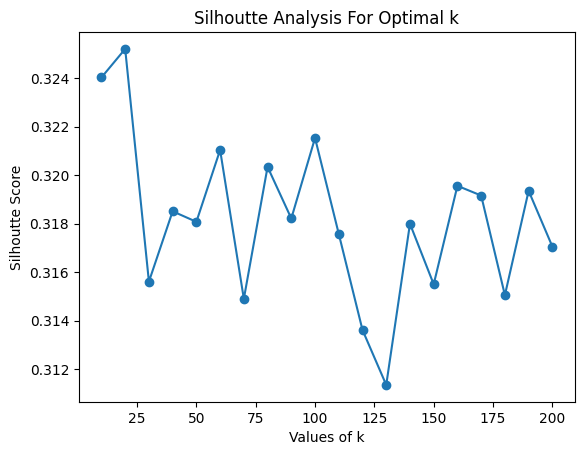

In [28]:
print('\n\n\x1b[1;31m'+'Silhoutte Analysis For Optimal k :'+'\x1b[0m\n\n')
plt.plot(range(10, 201, 10), silhouette_avg_kmeans, marker='o')
plt.xlabel('Values of k') 
plt.ylabel('Silhoutte Score') 
plt.title('Silhoutte Analysis For Optimal k')
plt.show()



Elbow Method For Optimal k :




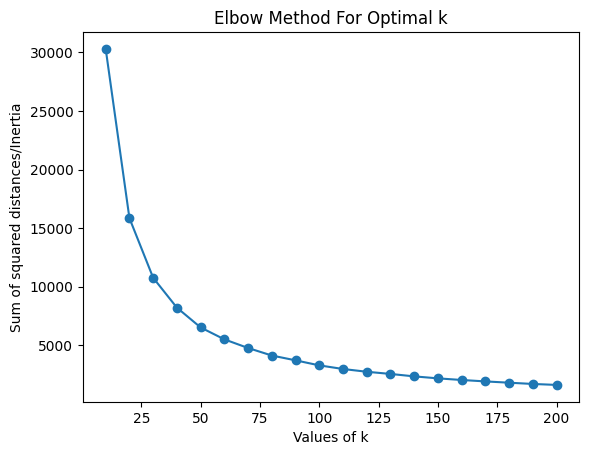

In [29]:
print('\n\n\x1b[1;31m'+'Elbow Method For Optimal k :'+'\x1b[0m\n\n')
plt.plot(range(10, 201, 10), inertia_list_kmeans, marker='o')
plt.xlabel('Values of k') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [92]:
num_clusters = 20
kmeans = KMeans(n_clusters=20, random_state=42, n_init='auto')
kmeans.fit(X_train)

y_pred_kmeans = kmeans.predict(X_test)

# Calculate accuracy and inertia
accuracy = accuracy_score(y_test, y_pred_kmeans)
inertia = kmeans.inertia_

# Append accuracy and inertia to the lists
print('\n\x1b[1;31m'+'Clusters :'+'\x1b[0m', num_clusters)
print('\x1b[1;31m'+'Accuracy :'+'\x1b[0m', accuracy*100, '%')
print('\x1b[1;31m'+'Inertia :'+'\x1b[0m', inertia)
print('\x1b[1;31m'+'Silhoutte Average :'+'\x1b[0m', silhouette_score(X_test, y_pred_kmeans))


Clusters : 20
Accuracy : 3.8761851645287226 %
Inertia : 15860.71562139212
Silhoutte Average : 0.31943650284499914


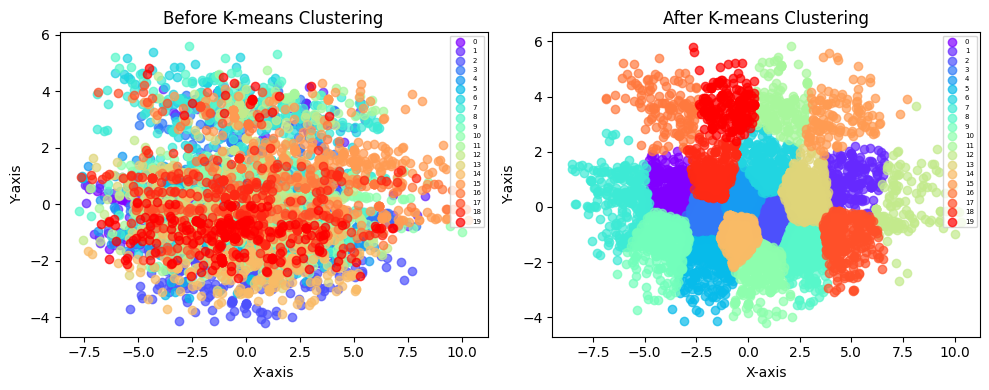

In [93]:
plt.figure(figsize=(10,4))

# Plot before clustering
plt.subplot(1, 2, 1)
colors = plt.cm.rainbow(np.linspace(0, 1, 20))
for i,c in enumerate(colors):
  plt.scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], marker='o',color = c, label=i, alpha =0.7)
plt.legend(fontsize=5, title_fontsize=5)
plt.title('Before K-means Clustering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Plot after clustering
plt.subplot(1, 2, 2)
colors = plt.cm.rainbow(np.linspace(0, 1, 20))
for i,c in enumerate(colors):
  plt.scatter(X_test[y_pred_kmeans==i, 0], X_test[y_pred_kmeans==i, 1], marker='o',color = c, label=i, alpha =0.7)
plt.legend(fontsize=5, title_fontsize=5)
plt.title('After K-means Clustering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.tight_layout()
plt.show()

The most suitable cluster count appears to be 20, as observed from the point where the Silhouette score reaches its peak, followed by a slight decline before gradually rising again. Moreover, the elbow method suggests an optimal k value around 20, marking a notable inflection point in the plot. This optimal number is reinforced by utilizing both the Silhouette Method and the Elbow Method in conjunction, strengthening the confidence in determining the ideal number of clusters

#### [3] Apply the fuzzy k-means algorithm to Sign Language MNIST dataset. 

#### a. Change the number of clusters from 10 to 200 with the step size of 10. Show the performance of the algorithm based on accuracy and the objective function value for each cluster number.

In [87]:
# Lists to store accuracy, objective function and silhouette avg values for each cluster count
accuracy_list_fcm = []
objective_function_list_fcm = []
silhouette_avg_fcm = []

for num_clusters in np.arange(10, 201, 10):
    # Fuzzy K-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_train.T, num_clusters, m=2, error=0.005, maxiter=200, init=None
    )
    
    # Predicting cluster labels for the test set
    u_test, u0_test, d_test, jm_test, p_test, fpc_test = fuzz.cluster.cmeans_predict(X_val.T, cntr, 2, error=0.005, maxiter=200)
    y_pred = np.argmax(u_test, axis=0)
    
    # Calculating accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_list_fcm.append(accuracy)
    
    objective_function_list_fcm.append(jm[-1])
    silhouette_avg_fcm.append(silhouette_score(X_val, y_pred))

In [88]:
j = 0
for i in range(10, 201, 10):
    print('\n\x1b[1;31m'+'Clusters :'+'\x1b[0m', i)
    print('\x1b[1;31m'+'Accuracy :'+'\x1b[0m', accuracy_list_fcm[j]*100, '%')
    print('\x1b[1;31m'+'Objective Function :'+'\x1b[0m', objective_function_list_fcm[j])
    print('\x1b[1;31m'+'Silhoutte Average :'+'\x1b[0m', silhouette_avg_fcm[j])
    j+=1


Clusters : 10
Accuracy : 3.077763613185212 %
Objective Function : 13041.229441263124
Silhoutte Average : 0.30768772480701195

Clusters : 20
Accuracy : 3.9701329448187948 %
Objective Function : 5712.478111992527
Silhoutte Average : 0.2955477331794089

Clusters : 30
Accuracy : 3.7515935166636316 %
Objective Function : 3564.561226643499
Silhoutte Average : 0.2899062576071015

Clusters : 40
Accuracy : 2.2400291385904207 %
Objective Function : 2552.7054699784608
Silhoutte Average : 0.2893426121290873

Clusters : 50
Accuracy : 1.8940083773447458 %
Objective Function : 1976.1379318421018
Silhoutte Average : 0.28271591115883543

Clusters : 60
Accuracy : 1.7118921872154433 %
Objective Function : 1600.6408735346645
Silhoutte Average : 0.2908806590863176

Clusters : 70
Accuracy : 1.2019668548533966 %
Objective Function : 1353.4561958567706
Silhoutte Average : 0.28201461449108994

Clusters : 80
Accuracy : 2.22181751957749 %
Objective Function : 1153.2358437812863
Silhoutte Average : 0.27397938273



Silhoutte Analysis For Optimal k :




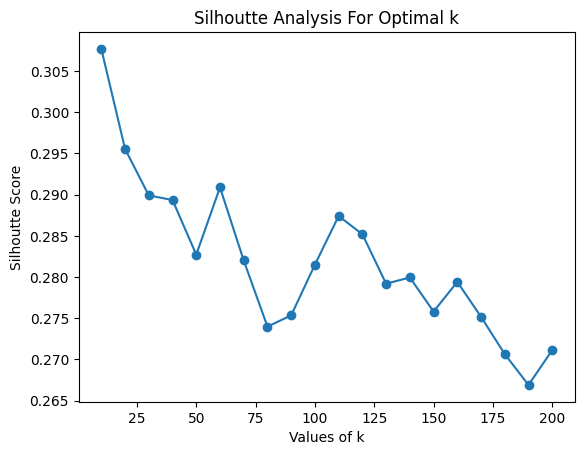

In [89]:
print('\n\n\x1b[1;31m'+'Silhoutte Analysis For Optimal k :'+'\x1b[0m\n\n')
plt.plot(range(10, 201, 10), silhouette_avg_fcm, marker='o')
plt.xlabel('Values of k') 
plt.ylabel('Silhoutte Score') 
plt.title('Silhoutte Analysis For Optimal k')
plt.show()



Elbow Method For Optimal k :




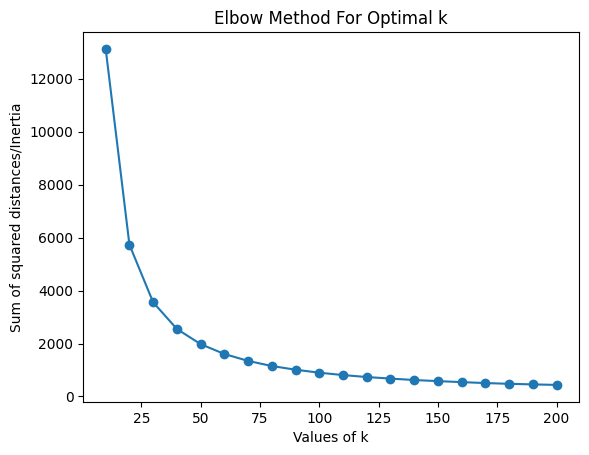

In [63]:
print('\n\n\x1b[1;31m'+'Elbow Method For Optimal k :'+'\x1b[0m\n\n')
plt.plot(range(10, 201, 10), objective_function_list_fcm, marker='o')
plt.xlabel('Values of k') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

#### b. Show the performance of the algorithm based on accuracy and the objective function value by changing the fuzzifier value from 1 to 5 with the step size of 1.

In [64]:
# Initialize lists to store performance metrics
accuracy_list = []
objective_function_list = []
silhouette_avg = []

num_clusters=20

# Varying the fuzzifier value from 1.1 to 5
# The value cannot be 1 as it throws DivideByZero error for starting from 1.1 in this case
for m_value in [1.1, 2, 3, 4, 5]:
    # Fuzzy K-means clustering with varying fuzzifier value
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_train.T, num_clusters, m=m_value, error=0.005, maxiter=1000, init=None
    )

    # Predicting cluster labels for the validation set
    u_test, u0_test, d_test, jm_test, p_test, fpc_test = fuzz.cluster.cmeans_predict(
        X_val.T, cntr, m=m_value, error=0.005, maxiter=1000
    )
    
    y_pred = np.argmax(u_test, axis=0)

    # Calculating accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_list.append(accuracy)

    # Objective function value
    objective_function_list.append(jm[-1])

    # Silhouette score
    silhouette_avg.append(silhouette_score(X_val, y_pred))

j = 0
for i in [1.1, 2, 3, 4, 5]:
    print('\n\x1b[1;31m'+'Fuzzier Value :'+'\x1b[0m', i)
    print('\x1b[1;31m'+'Accuracy :'+'\x1b[0m', accuracy_list[j]*100, '%')
    print('\x1b[1;31m'+'Objective Function :'+'\x1b[0m', objective_function_list[j])
    print('\x1b[1;31m'+'Silhoutte Average :'+'\x1b[0m', silhouette_avg[j])
    j+=1


Fuzzier Value : 1.1
Accuracy : 2.695319613913677 %
Objective Function : 15881.284565640146
Silhoutte Average : 0.31898606997622175

Fuzzier Value : 2
Accuracy : 4.261518849025679 %
Objective Function : 5729.175169482153
Silhoutte Average : 0.29521344240425795

Fuzzier Value : 3
Accuracy : 4.552904753232562 %
Objective Function : 452.62804182381535
Silhoutte Average : 0.1964151461431643

Fuzzier Value : 4
Accuracy : 2.9502822800947004 %
Objective Function : 25.342097591595962
Silhoutte Average : 0.11772764484877916

Fuzzier Value : 5
Accuracy : 3.7151702786377707 %
Objective Function : 1.3262874835196343
Silhoutte Average : 0.05070670601849837


In [90]:
num_clusters=20
m_value=3

# Fuzzy K-means clustering with varying fuzzifier value
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_train.T, num_clusters, m_value, error=0.005, maxiter=1000, init=None
)

# Predicting cluster labels for the validation set
u_test, u0_test, d_test, jm_test, p_test, fpc_test = fuzz.cluster.cmeans_predict(
    X_test.T, cntr, m_value, error=0.005, maxiter=1000
)

y_pred_fcm = np.argmax(u_test, axis=0)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_fcm)
print('\x1b[1;31m'+'Accuracy :'+'\x1b[0m', accuracy*100, '%')
print('\x1b[1;31m'+'Objective Function :'+'\x1b[0m', jm[-1])
print('\x1b[1;31m'+'Silhoutte Average :'+'\x1b[0m', silhouette_score(X_test, y_pred_fcm))

Accuracy : 2.3703290574456215 %
Objective Function : 448.3808368240723
Silhoutte Average : 0.2087975980546246


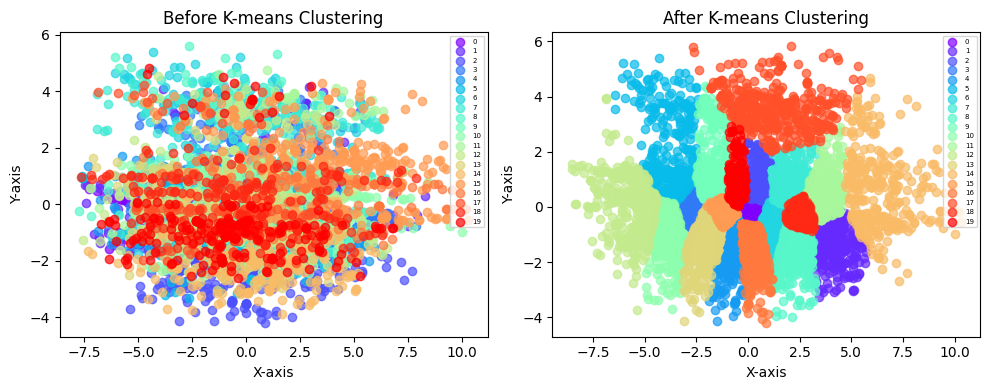

In [91]:
plt.figure(figsize=(10,4))

# Plot before clustering
plt.subplot(1, 2, 1)
colors = plt.cm.rainbow(np.linspace(0, 1, 20))
for i,c in enumerate(colors):
  plt.scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], marker='o',color = c, label=i, alpha =0.7)
plt.legend(fontsize=5, title_fontsize=5)
plt.title('Before K-means Clustering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Plot after clustering
plt.subplot(1, 2, 2)
colors = plt.cm.rainbow(np.linspace(0, 1, 20))
for i,c in enumerate(colors):
  plt.scatter(X_test[y_pred_fcm==i, 0], X_test[y_pred_fcm==i, 1], marker='o',color = c, label=i, alpha =0.7)
plt.legend(fontsize=5, title_fontsize=5)
plt.title('After K-means Clustering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.tight_layout()
plt.show()

#### c. Compare k-means and FCM based on the results that you achieved. 

Results for K-means :
Confusion Matrix:


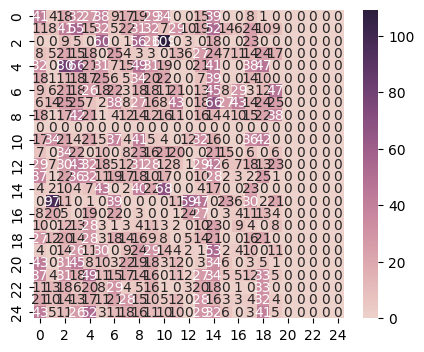

Accuracy: 0.04
Precision: 0.04
Recall: 0.04
F1 Score: 0.04
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.12      0.11       331
           1       0.03      0.02      0.02       432
           2       0.02      0.03      0.02       310
           3       0.03      0.06      0.04       245
           4       0.04      0.04      0.04       498
           5       0.07      0.10      0.08       247
           6       0.07      0.06      0.06       348
           7       0.03      0.02      0.02       436
           8       0.03      0.05      0.03       288
           9       0.00      0.00      0.00         0
          10       0.01      0.01      0.01       331
          11       0.10      0.10      0.10       209
          12       0.01      0.00      0.00       394
          13       0.02      0.03      0.03       291
          14       0.02      0.07      0.04       246
          15       0.18      0.07      0.10       347

In [105]:
print('\x1b[1;31m'+'Results for K-means :'+'\x1b[0m')

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_kmeans)
print("Confusion Matrix:")

plt.figure(figsize=(5,4))
sns.heatmap(
    conf_matrix, annot = True,
    fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)
)
plt.show()


# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred_kmeans)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and display precision, recall, and F1 score
precision = precision_score(y_test, y_pred_kmeans, average='micro')
recall = recall_score(y_test, y_pred_kmeans, average='micro')
f1 = f1_score(y_test, y_pred_kmeans, average='micro')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_kmeans, zero_division=0))

Results for FCM :
Confusion Matrix:


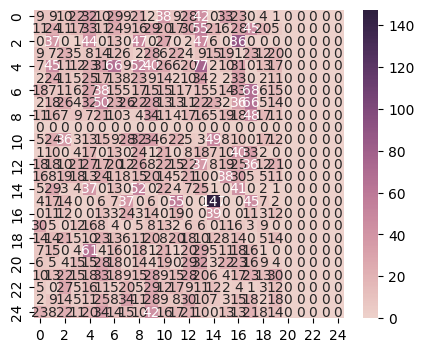

Accuracy: 0.02
Precision: 0.03
Recall: 0.02
F1 Score: 0.02
Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.03      0.03       331
           1       0.06      0.06      0.06       432
           2       0.00      0.00      0.00       310
           3       0.02      0.02      0.02       245
           4       0.05      0.05      0.05       498
           5       0.04      0.07      0.05       247
           6       0.04      0.04      0.04       348
           7       0.10      0.06      0.07       436
           8       0.01      0.01      0.01       288
           9       0.00      0.00      0.00         0
          10       0.02      0.02      0.02       331
          11       0.00      0.00      0.00       209
          12       0.06      0.06      0.06       394
          13       0.02      0.03      0.02       291
          14       0.00      0.00      0.00       246
          15       0.00      0.00      0.00       347

In [166]:
print('\x1b[1;31m'+'Results for FCM :'+'\x1b[0m')

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_fcm)
print("Confusion Matrix:")

plt.figure(figsize=(5,4))
sns.heatmap(
    conf_matrix, annot = True,
    fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)
)
plt.show()


# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred_fcm)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and display precision, recall, and F1 score
precision = precision_score(y_test, y_pred_fcm, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_fcm, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_fcm, average='weighted', zero_division=0)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_fcm, zero_division=0))

### Comparison:
- **Accuracy:** K-means outperforms FCM in terms of accuracy, indicating that K-means achieved a higher ratio of correctly classified samples.
- **Precision, Recall, and F1 Score:** Both K-means and FCM exhibit similar performance across these metrics, with very low scores. Precision indicates the proportion of correctly identified instances among the instances predicted as positive; Recall measures the proportion of actual positive instances that were correctly identified; F1 Score is the harmonic mean of Precision and Recall. The low scores suggest poor performance in capturing true positives and minimizing false positives/negatives for both algorithms.

### Analysis:
- **Interpretation of Results:** The low values of Precision, Recall, and F1 Score indicate that both algorithms might struggle in correctly classifying the data points into distinct clusters or classes. The clusters formed by both algorithms might not align well with the ground truth labels.
- **Limitations:** The low performance could be due to various factors such as noisy data, inappropriate choice of clustering algorithms for the given data distribution, or inadequate preprocessing of data before clustering.

### Conclusion:
- **Both K-means and FCM** seem to have limitations in effectively capturing the underlying structure in the data, as reflected by the low performance across multiple metrics.


#### [4] Implement a feedforward neural network and train the network. This network will be trained and tested using the train and test sets of the dataset. Specifically, given an input image (28 x 28 = 784 pixels) from the Sign-MNIST dataset, the network will be trained to classify the image into 1 of 24 classes.

In [138]:
def fix_label_gap(l):
    if(l>=9):
        return (l-1)
    else:
        return l

X_train = training_data.drop('label', axis=1).values
y_train = training_data['label'].apply(fix_label_gap).values
y_train = to_categorical(y_train, num_classes=24)

X_test = testing_data.drop('label', axis=1).values
y_test = testing_data['label'].apply(fix_label_gap).values
y_test = to_categorical(y_test, num_classes=24)

# Reshape the data (assuming grayscale images)
X_train = X_train.reshape(-1 , 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

#### a. Develop a simple Convolutional Neural Network with maximum 10 hidden layers composed of convolutional, pooling and fully connected layers. Design and build your model. Specify kernel sizes, number of filters, activation functions, learning rate, optimization, and loss functions of your model.

In [154]:
# Define model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(24, activation='softmax'))  # Output layer with 24 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)
y_pred = model.predict(X_test)
accuracy = accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))
print('\x1b[1;31m'+'Accuracy :'+'\x1b[0m', accuracy)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Epoch 1/10
687/687 [==============================] - 3s 4ms/step - loss: 1.0154 - accuracy: 0.6965 - val_loss: 0.1812 - val_accuracy: 0.9494
Epoch 2/10
687/687 [==============================] - 3s 4ms/step - loss: 0.0738 - accuracy: 0.9855 - val_loss: 0.0218 - val_accuracy: 0.9984
Epoch 3/10
687/687 [==============================] - 3s 4ms/step - loss: 0.0123 - accuracy: 0.9990 - val_loss: 0.0107 - val_accuracy: 0.9998
Epoch 4/10
687/687 [==============================] - 3s 4ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/10
687/687 [==============================] - 3s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 7.7934e-04 - val_accuracy: 1.0000
Epoch 6/10
687/687 [==============================] - 3s 4ms/step - loss: 5.5250e-04 - accuracy: 1.0000 - val_loss: 4.8180e-04 - val_accuracy: 1.0000
Epoch 7/10
687/687 [==============================] - 3s 4ms/step - loss: 3.5634e-04 - accuracy: 1.0000 - val_loss: 6.0043e-04 - val_acc

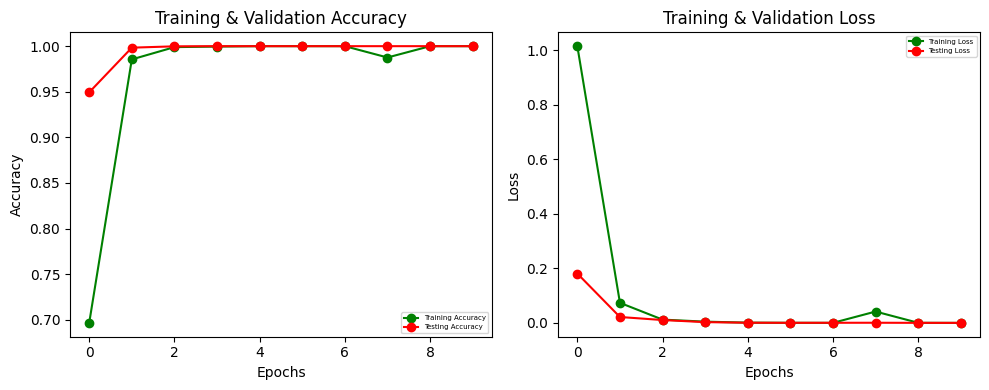

In [156]:
plt.figure(figsize=(10,4))
epochs = [i for i in range(10)]

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'go-' , label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'ro-' , label = 'Testing Accuracy')
plt.legend(fontsize=5, title_fontsize=5)
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'g-o' , label = 'Training Loss')
plt.plot(epochs, val_loss, 'r-o' , label = 'Testing Loss')
plt.legend(fontsize=5, title_fontsize=5)
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

#### b. Plot the confusion matrix and evaluate the performance of your classification model.

Results for Neural Network :
Confusion Matrix:


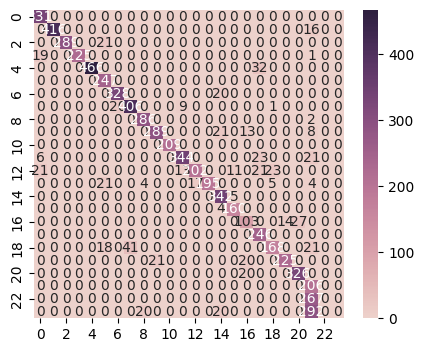

Accuracy: 0.84
Precision: 0.83
Recall: 0.84
F1 Score: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       331
           1       1.00      0.96      0.98       432
           2       1.00      0.93      0.96       310
           3       1.00      0.92      0.96       245
           4       1.00      0.94      0.97       498
           5       0.80      1.00      0.89       247
           6       0.94      0.94      0.94       348
           7       0.91      0.93      0.92       436
           8       0.92      0.99      0.96       288
           9       0.93      0.87      0.90       331
          10       1.00      1.00      1.00       209
          11       0.94      0.87      0.91       394
          12       0.92      0.69      0.79       291
          13       1.00      0.79      0.88       246
          14       0.84      0.99      0.91       347
          15       0.91      0.98      0.94       164

In [163]:
print('\x1b[1;31m'+'Results for Neural Network :'+'\x1b[0m')

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print("Confusion Matrix:")

plt.figure(figsize=(5,4))
sns.heatmap(
    conf_matrix, annot = True,
    fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)
)
plt.show()


# Calculate and display accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {accuracy:.2f}")

# Calculate and display precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division=0)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Display the classification report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), zero_division=0))

### References :
[1] IBM documentation. (2021, April 8). Ibm.com. https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet <br>
[2] Seaborn.Heatmap — seaborn 0.13.0 documentation. (n.d.). Pydata.org. Retrieved October 3, 2023, from https://seaborn.pydata.org/generated/seaborn.heatmap.html <br>
[3] Banerji, A. (2021, May 18). K-mean: Getting the optimal number of clusters. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/<br>
[4] Pramoditha, R. (2023, January 3). 3 easy steps to perform dimensionality reduction using principal component analysis (PCA). Data Science 365. https://medium.com/data-science-365/3-easy-steps-to-perform-dimensionality-reduction-using-principal-component-analysis-pca-79121998b991<br>
[5] Allibhai, J. (2018, October 16). Building a convolutional neural network (CNN) in keras. Towards Data Science. https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5<br>
[6] Gupta, A. (2021, June 2). Fuzzy C-means clustering (FCM) algorithm - geek culture - medium. Geek Culture. https://medium.com/geekculture/fuzzy-c-means-clustering-fcm-algorithm-in-machine-learning-c2e51e586fff<br>



